# A Tutorial on Sparsity via Regularisation 

This file is created as a trial of sparsity on a regression example. We consider a dataset with p features and n sample. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or
$X \sim \mathcal{N}(\mu, \sigma^2)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta+\epsilon \\
\epsilon &\sim \mathcal{N}(\mu, \sigma^2)
\end{align*}

In [535]:
import numpy as np
import matplotlib.pyplot as plt

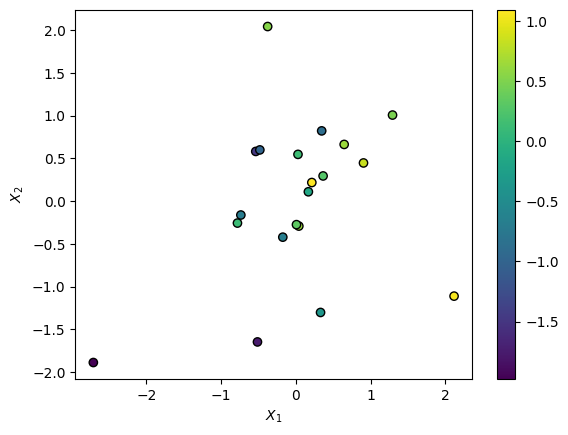

In [536]:
RNG = np.random.default_rng(seed=1)
p = 2
n = 20
var = 1
cov = var*np.eye(p)
mean = np.zeros(p)
sigma = 1

# To define the weights as beta
beta = np.array([1, 0]) 

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n)
y = x@beta + RNG.normal(0, sigma**2, size=n)

# To show the dataset
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.colorbar()
plt.show()

The loss function also is defined as a squared norm of residuals as 

\begin{equation*}
Loss\;Function=\vert\vert X\beta - Y\vert\vert_2^2
\end{equation*}

In [537]:
# To define the loss function
# def squared_error(beta):
#     return np.linalg.norm(x.dot(np.atleast_2d(beta).T) - y.reshape(-1, 1), axis=0)**2

# To define another form of loss function
def squared_error(beta):  ## Sum of abs residuals (norm 1)
    beta = np.reshape(beta,(-1, 2))
    return np.sum(abs(beta@x.T-y)**2,axis=1)

In [538]:
# To check the loss function
squared_error(beta)

array([10.26943722])

Then we define a space of 2 dimensions for all probable $\beta \subset \mathcal{R}^2$ and calculate the loss function for this space. After that the residuals (errors) corresponding to the all $\beta$
estimation space and real output would be calculated.

In [539]:
# To define the estimation space of beta
_beta1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[0]
_beta2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[1]
_beta = np.dstack((_beta1, _beta2))
_beta = np.reshape(_beta, (-1,2))
# _beta.shape

In [540]:
# To calculate the residuals between real output "y" and estimation space "x*_beta"
# error_space = squared_error(_beta)
# error_space

Now here we find the best estimated weights by least square optimization method.

In [541]:
# To define beta_hat by least square mathod
beta_hat = np.linalg.solve(x.T.dot(x), x.T.dot(y))
# least square in another calculation
# beta_hat = (np.linalg.inv(x.T@x)@x.T)@y
# beta_hat

Here we add a regularization (penalty/punishemnt) term to the loss function to sparse the solution space. It would be written as follows

\begin{equation*} 
Regularized\;Loss\;Function = \vert\vert X\beta - Y\vert\vert_2^2 + \alpha*\vert\vert \beta \vert\vert 
\end{equation*}

The final goal is to obtain $\beta$ which minimize the regularized loss function. 

\begin{equation*} 
\hat{\beta} = \underset{\beta \in \mathcal{R}^2}{argmin} \; \vert\vert X\beta - Y\vert\vert_2^2 + \alpha*\vert\vert \beta \vert\vert 
\end{equation*}

Now we try to define the piecewised penalty function as

\begin{equation*}
p(\beta) = \Bigg\{ 
    \begin{array}{rcl}
    \beta^2 + \frac{1}{2} & if & \beta < -\frac{1}{2} \\
    \vert \beta \vert & if & \vert \beta \vert \le \frac{1}{2}\\
    \vert \beta-1 \vert & if & \frac{1}{2} < \vert \beta \vert \le \frac{3}{2}\\
    \frac{2}{9}\beta^2 & if & \beta > \frac{3}{2}
    \end{array} 
\end{equation*}

In [542]:
from numpy.linalg import norm

# alpha=100
# def regularised_error(beta):
#     return squared_error(beta) + alpha*norm(np.atleast_2d(beta), 1, axis=1)

# To define the regularized loss function
def regularised_error(beta,alpha):
    return squared_error(beta) + alpha*np.sum(abs(np.reshape(beta,(-1,2))),axis=1)


In [543]:
# To define the regularized loss function with piecewise penalty term
# def sparsed_regularised_error(beta,alpha):
#     r = np.where(abs(beta)<=1, abs(beta), 0.5*beta**2+0.5)
#     return squared_error(beta) + alpha*np.sum(r)

def sparsed_regularised_error(beta,alpha):
    # p1 = np.where(abs(beta)<=0.5, abs(beta), beta**2+0.5)
    # p2 = np.where(0.5<=any(beta)<=1.5, abs(beta-1), beta**2-1.75)
    p = []
    for b in beta:
        if b<-0.5:
            p.append(b**2+0.5)
        elif abs(b)<=0.5:
            p.append(abs(b))
        elif b>=0.5 and b<=1.5:
            p.append(abs(b-1))
        else:
            p.append((2/9)*b**2)
    return squared_error(beta) + alpha*np.sum(p)




In [544]:
import scipy
from scipy.optimize import minimize
alpha=1
def minimizer(error_function, alpha):
    initial_beta = np.random.randint(p,size=(2))
    # initial_beta = np.array([0,0])
    # scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')
    result = minimize(error_function, initial_beta, method='Powell', args=(alpha), tol=1e-8)
    optimized_beta = result.x
    return optimized_beta
# scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')

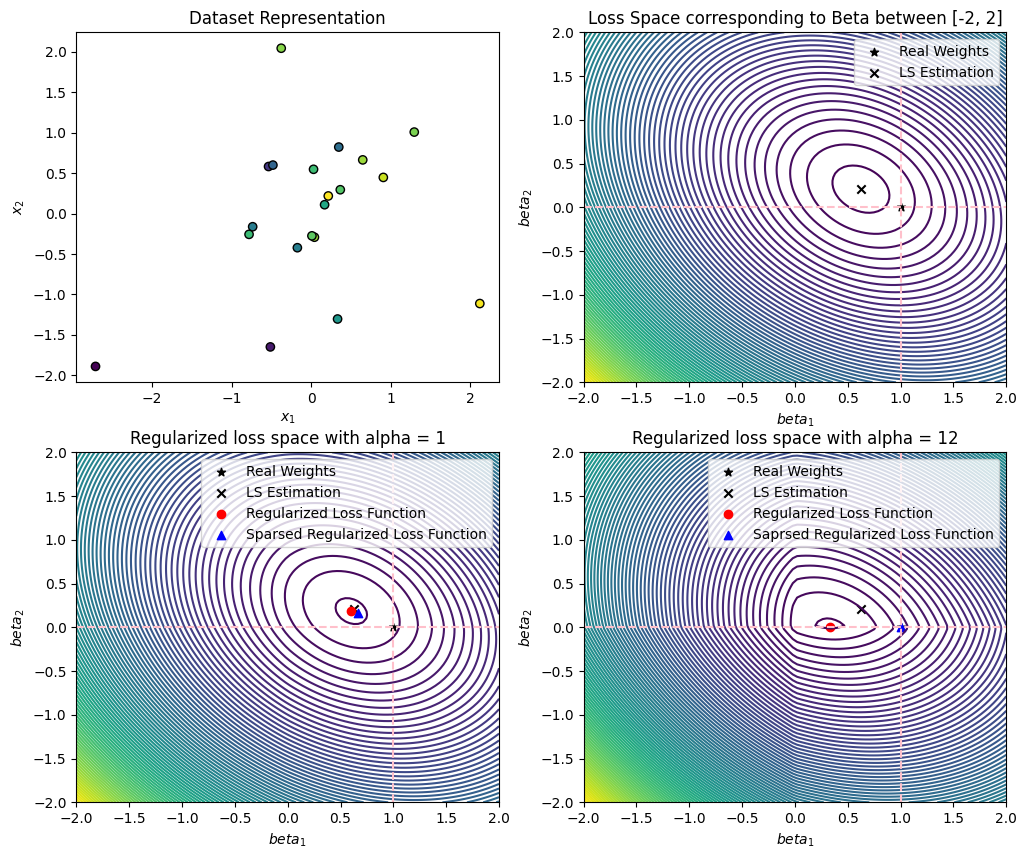

In [545]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0,0].scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
axs[0,0].set_xlabel('$x_1$')
axs[0,0].set_ylabel('$x_2$')
axs[0,0].title.set_text('Dataset Representation')

# axs[1].contourf(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), error_space.reshape(100, 100), levels=50, cmap='Reds')
axs[0,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), squared_error(_beta).reshape(100, 100), levels=100)
axs[0,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[0,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[0,1].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[0,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[0,1].set_xlabel('$beta_1$')
axs[0,1].set_ylabel('$beta_2$')
axs[0,1].legend()
axs[0,1].title.set_text('Loss Space corresponding to Beta between [-2, 2]')

a = 1
axs[1,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[1,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[1,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[1,0].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[1,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1,0].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='red', label='Regularized Loss Function')
axs[1,0].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='^', color='blue', label='Sparsed Regularized Loss Function')
axs[1,0].set_xlabel('$beta_1$')
axs[1,0].set_ylabel('$beta_2$')
axs[1,0].legend()
axs[1,0].title.set_text('Regularized loss space with alpha = '+ str(a))

a = 12
axs[1,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[1,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[1,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[1,1].scatter(beta[0], beta[1], marker='*', color='black', label='Real Weights')
axs[1,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1,1].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='red', label='Regularized Loss Function')
axs[1,1].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='^', color='blue', label='Saprsed Regularized Loss Function')
axs[1,1].set_xlabel('$beta_1$')
axs[1,1].set_ylabel('$beta_2$')
axs[1,1].legend()
axs[1,1].title.set_text('Regularized loss space with alpha = ' + str(a))

plt.show()

In [546]:
minimizer(sparsed_regularised_error,alpha=a)

array([1.00000000e+00, 4.30488219e-12])